In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_2)

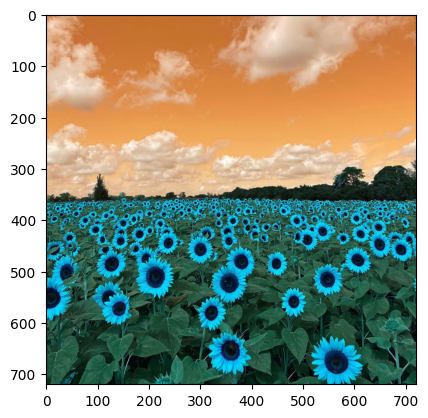

In [3]:
plt.imshow(im)

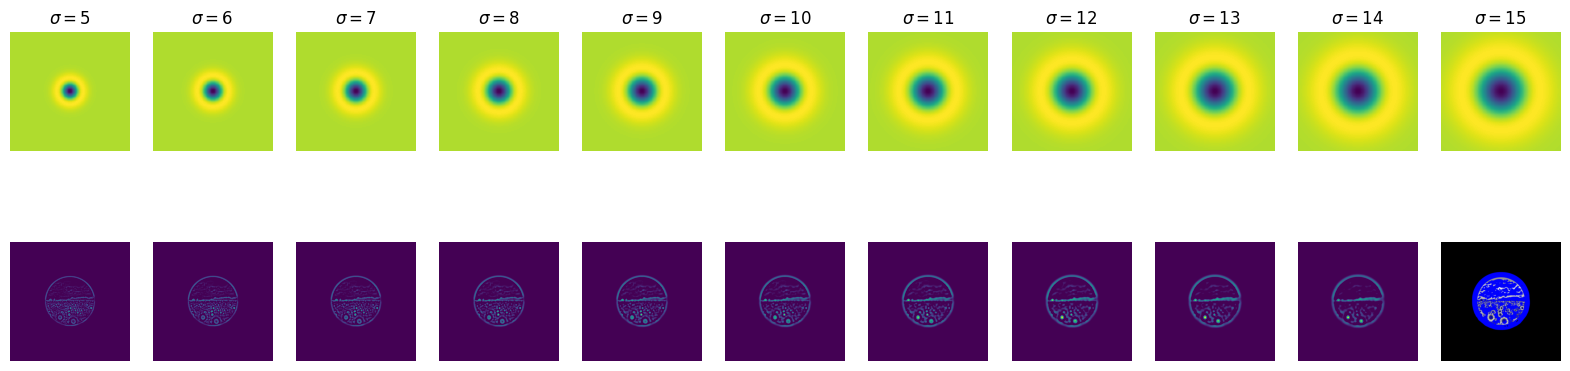

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

# Load your image
im = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Generate the Laplacian of Gaussian (LoG) filter
sigma = 10
hw = 3 * sigma
X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))
log = 1 / (2 * np.pi * sigma ** 2) * (X ** 2 / (sigma ** 2) + Y ** 2 / (sigma ** 2) - 2) * np.exp(
    -(X ** 2 + Y ** 2) / (2 * sigma ** 2))

# Create a binary mask to exclude regions you're not interested in
w, h = im.shape
hw, hh = w // 2, h // 2
r = w // 5  # Adjust the radius as needed

# Create a binary mask with the same shape as 'im'
mask = np.zeros_like(im, dtype=np.uint8)

# Calculate the center coordinates
center_x, center_y = hh, hw

# Create a circular mask
for x in range(im.shape[0]):
    for y in range(im.shape[1]):
        if (x - center_x) ** 2 + (y - center_y) ** 2 <= r ** 2:
            mask[x, y] = 1

# Apply the circular mask to the image
im = im * mask

# Initialize variables for scale-space representation
s = 11
scale_space = np.empty((h, w, s), dtype=np.float32)
sigmas = np.arange(5, 16, 1)

# Create subplots for visualization
fig, ax = plt.subplots(2, s, figsize=(20, 5))

# Loop through different sigma values and build scale-space representation
for i, sigma in enumerate(sigmas):
    log_hw = 3 * np.max(sigmas)
    X, Y = np.meshgrid(np.arange(-log_hw, log_hw + 1, 1), np.arange(-log_hw, log_hw + 1, 1))
    log = 1 / (2 * np.pi * sigma ** 2) * (X ** 2 / (sigma ** 2) + Y ** 2 / (sigma ** 2) - 2) * np.exp(
        -(X ** 2 + Y ** 2) / (2 * sigma ** 2))
    f_log = cv2.filter2D(im, -1, log)
    scale_space[:, :, i] = f_log
    ax[0, i].imshow(log)
    ax[0, i].axis('off')
    ax[0, i].set_title(r'$\sigma = {}$'.format(sigma))
    ax[1, i].imshow(f_log)
    ax[1, i].axis('off')

# Find local maxima in the scale-space representation
threshold = 0.05  # Adjust the threshold as needed
local_maxima = maximum_filter(scale_space, size=(3, 3, 3), mode='constant')
blobs = np.where((scale_space == local_maxima) & (scale_space > threshold))

# Access blob locations and corresponding sigma values
blob_locations = [(x, y, sigmas[z]) for x, y, z in zip(*blobs)]

# Draw circles around the detected blobs
output_image = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)  # Convert back to color
for blob in blob_locations:
    x, y, sigma = blob
    cv2.circle(output_image, (y, x), int(sigma), (0, 0, 255), 2)  # Draw a red circle

# Display the image with detected blobs
plt.imshow(output_image)
plt.show()


In [2]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("the_berry_farms_sunflower_field.jpeg",0) #gray scale conversion
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
k = 1.414
sigma = 1.0
img = img/255.0  #image normalization

In [3]:
def LoG(sigma):
    #window size 
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) *  (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter

In [4]:
def LoG_convolve(img):
    log_images = [] #to store responses
    for i in range(0,9):
        y = np.power(k,i) 
        sigma_1 = sigma*y #sigma 
        filter_log = LoG(sigma_1) #filter generation
        image = cv2.filter2D(img,-1,filter_log) # convolving image
        image = np.pad(image,((1,1),(1,1)),'constant') #padding 
        image = np.square(image) # squaring the response
        log_images.append(image)
    log_image_np = np.array([i for i in log_images]) # storing the #in numpy array
    return log_image_np
log_image_np = LoG_convolve(img)
#print(log_image_np.shape)

In [5]:
def detect_blob(log_image_np):
    co_ordinates = [] #to store co ordinates
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2] #9*3*3 slice
            result = np.amax(slice_img) #finding maximum
            if result >= 0.03: #threshold
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma)) #finding co-rdinates
    return co_ordinates
co_ordinates = list(set(detect_blob(log_image_np)))

In [6]:
fig, ax = plt.subplots()
nh,nw = img.shape
count = 0

ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=0.2, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

KeyboardInterrupt: 

In [41]:
import cv2 as cv
import numpy as np

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Define a range of sigma values to test
sigma_values = np.linspace(1, 30, 30)

# Initialize a list to store detected circles
circles = []

# Create a SimpleBlobDetector parameters object
params = cv.SimpleBlobDetector_Params()

# Set parameters for blob detection
params.minThreshold = 0
params.maxThreshold = 255
params.thresholdStep = 1
params.minRepeatability = 1  # Set to 1 or more
params.filterByArea = True
params.minArea = 10
params.filterByColor = True
params.blobColor = 255
params.filterByCircularity = False
params.filterByInertia = False
params.filterByConvexity = False

# Create a blob detector with the specified parameters
detector = cv.SimpleBlobDetector_create(params)

# Detect circles for each sigma value
for sigma in sigma_values:
    # Apply LoG filter to the grayscale image and convert it to 8-bit
    blurred = cv.GaussianBlur(gray, (0, 0), sigmaX=sigma)
    log = cv.Laplacian(blurred, cv.CV_8U)  # Convert to 8-bit

    # Detect blobs (circles) in the 8-bit LoG image
    keypoints = detector.detect(log)

    # Add detected circles to the list
    for keypoint in keypoints:
        x, y, s = keypoint.pt[0], keypoint.pt[1], keypoint.size
        circles.append((int(x), int(y), int(s), sigma))

# Find the largest circle among the detected circles
if circles:
    largest_circle = max(circles, key=lambda x: x[2])
    x, y, radius, sigma = largest_circle
    print("Parameters of the largest circle:")
    print(f"Center: ({x}, {y})")
    print(f"Radius: {radius}")
    print(f"Sigma used: {sigma}")
else:
    print("No circles detected.")


Parameters of the largest circle:
Center: (243, 222)
Radius: 121
Sigma used: 25.0


In [38]:
import cv2 as cv
import numpy as np

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Define a range of sigma values to test
sigma_values = np.linspace(1, 30, 30)

# Initialize variables to store the largest circle and its parameters
largest_circle = None
max_radius = 0
max_sigma = 0

for sigma in sigma_values:
    # Apply Gaussian blur with the current sigma
    blurred = cv.GaussianBlur(gray, (0, 0), sigmaX=sigma, sigmaY=sigma)
    
    # Detect circles using Hough Circle Transform
    circles = cv.HoughCircles(
        blurred, cv.HOUGH_GRADIENT, dp=1, minDist=20, param1=50, param2=30, minRadius=0, maxRadius=0
    )
    
    # If circles were detected, find the largest one
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0]:
            if circle[2] > max_radius:
                max_radius = circle[2]
                max_sigma = sigma
                largest_circle = circle

# Check if a circle was detected
if largest_circle is not None:
    x, y, radius = largest_circle
    print("Parameters of the largest circle:")
    print(f"Center: ({x}, {y})")
    print(f"Radius: {radius}")
    print(f"Sigma used: {max_sigma}")
else:
    print("No circles detected.")


Parameters of the largest circle:
Center: (140, 8)
Radius: 234
Sigma used: 2.0


In [43]:
import cv2 as cv
import numpy as np

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Define a range of sigma values to test
sigma_values = np.linspace(1, 30, 30)

# Initialize a list to store detected circles
circles = []

# Create a SimpleBlobDetector parameters object
params = cv.SimpleBlobDetector_Params()

# Set parameters for blob detection
params.minThreshold = 0
params.maxThreshold = 255
params.thresholdStep = 1
params.minRepeatability = 1  # Set to 1 or more
params.filterByArea = True
params.minArea = 10
params.filterByColor = True
params.blobColor = 255
params.filterByCircularity = False
params.filterByInertia = False
params.filterByConvexity = False

# Create a blob detector with the specified parameters
detector = cv.SimpleBlobDetector_create(params)

# Detect circles for each sigma value
for sigma in sigma_values:
    # Apply LoG filter to the grayscale image and convert it to 8-bit
    blurred = cv.GaussianBlur(gray, (0, 0), sigmaX=sigma)
    log = cv.Laplacian(blurred, cv.CV_8U)  # Convert to 8-bit

    # Detect blobs (circles) in the 8-bit LoG image
    keypoints = detector.detect(log)

    # Add detected circles to the list
    for keypoint in keypoints:
        x, y, s = keypoint.pt[0], keypoint.pt[1], keypoint.size
        circles.append((int(x), int(y), int(s), sigma))

# Find the largest circle among the detected circles
if circles:
    largest_circle = max(circles, key=lambda x: x[2])
    x, y, radius, sigma = largest_circle
    print("Parameters of the largest circle:")
    print(f"Center: ({x}, {y})")
    print(f"Radius: {radius}")
    print(f"Sigma used: {sigma}")
    
    # Draw all detected circles on the image
    for circle in circles:
        x, y, r, _ = circle
        cv.circle(im, (x, y), r, (0, 255, 0), 2)  # Green circle with a thickness of 2
else:
    print("No circles detected.")

# Display the image with the detected circles
cv.imshow('Detected Circles', im)
cv.waitKey(0)
cv.destroyAllWindows()


Parameters of the largest circle:
Center: (243, 222)
Radius: 121
Sigma used: 25.0


# Question 2

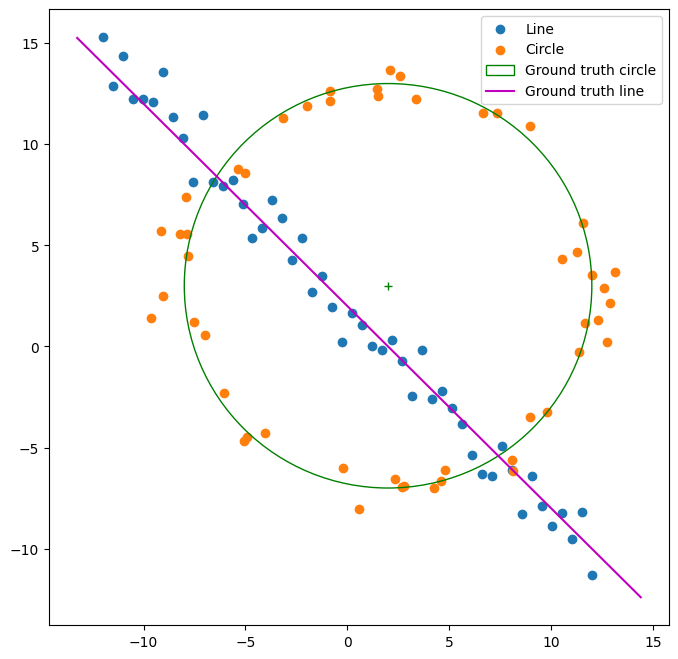

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import linalg

# Set the random seed for reproducibility (optional)
# np.random.seed(0)

N = 100
half_n = N // 2

# Circle parameters
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Line parameters
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

# Create a scatter plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()
